# Galaxy Selection function [#120](https://github.com/qezlou/LIM_LyTomo/issues/120):

We use halo abundacne matching to find the halo mass cut for the mock galaxy surveys. It depends on how many phtometric bands are used and what magnitude cut we want to place. These also determine the median photometric redshfit uncertainty for the selected sample. 

- CLAUDS+NIR observation paper is on arxiv : [Desprez+23](https://arxiv.org/pdf/2301.13750.pdf). 
- The data is [here](https://www.clauds.net/available-data)

In [2]:
from astropy.io import fits
import numpy as np
import h5py
import importlib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Notebook.mystyle')

In [3]:
from astropy.cosmology import Planck15 as cosmo
def get_num_density(counts, area, zrange=(2,3)):
    dz=0.01
    solid_angle = area*(np.pi/180)**2
    z = np.arange(zrange[0],zrange[1],dz)
    vol = solid_angle*np.sum(cosmo.differential_comoving_volume(z)*dz)*cosmo.h**3
    ndens = (counts/vol).value

    return ndens

In [4]:
def get_mass_complteness(ndens, labels):
    fig, ax = plt.subplots(1,1)
    colors=['C0','C1','C2','C3']
    ls = ['solid','dashed','dotted','-.']
    with h5py.File('/home/mahdi/HD2/LIM/cumulative_mass_function.hdf5','r') as f:
        mass = 10-f['x'][:]
        ndens_sim = f['cumcounts'][:]/250**3
        ax.plot(mass, ndens_sim)
        ax.set_yscale('log')
        ax.grid(axis='both', which='both')
    print('')
    print('Mass completeness :')
    print('..........................')
    for i in range(len(ndens)):
        print(labels[i]+'  '+str(mass[np.argmin(np.abs(ndens_sim - ndens[i]))]))
        ax.axhline(ndens[i], label=labels[i], color=colors[i], ls=ls[i])
    ax.legend(framealpha=0)
    ax.set_ylabel(r'$n[1/cMpc/h]^3$')


## Magnitude cut:

The SEctractor catalog should be compareable to the HSC-pipe catalogue. But it has the infereed absolute magnitude recorded, I can use that to find the photoz uncertainties at different magnitude bins.

In [9]:
def read_sextractor(file_path):
    all_photz = np.array([])
    all_zacc = np.array([])
    all_mag = np.array([])
    for fpath in file_path:
        with fits.open(fpath) as hdul:
            data = hdul[1].data
            #print(hdul[1].header)
            photz = data.field('Z_BEST')
            all_photz = np.append(all_photz, photz)
            all_zacc = np.append(all_zacc, (data.field('Z_BEST68_HIGH') - data.field('Z_BEST68_LOW'))/(2*(1+photz)))
            all_mag = np.append(all_mag, data.field('i'))

    return all_photz, all_zacc, all_mag

In [10]:
def get_photz_dist_sextractor(file_paths, labels, area, zmin=2, zmax=3, mag_cut = 99):

    fig, ax = plt.subplots(1,3, figsize=(25,7))
    ls = ['solid', 'dashed','dotted','-.']
    counts, sigma_z = [], []

    for i in range(len(file_paths)):
        photz, zacc, mag = read_sextractor(file_path=file_paths[i])

        ind = np.where((photz >= zmin)*(photz<=zmax)*(mag <= mag_cut)*((mag >=0)))[0]
        ax[0].hist(photz[ind], label=labels[i], ls=ls[i], histtype='step')
        ax[1].hist(zacc[ind], label=labels[i], ls=ls[i], histtype='step')
        ax[2].hist(mag[ind], histtype='step', label=labels[i], ls=ls[i])
        counts.append(ind.size)
        sigma_z.append(np.median(zacc[ind]))
    counts = np.array(counts)
    counts_per_comaprison = (counts* 1.3/ area).astype(int)
    print('counts:')
    print('..........................')
    for i in range(len(file_paths)):
        print(f'{labels[i]}, {counts[i]/1000} k')
    print('')
    print('Counts per 1.3 deg^2 :')
    print('..........................')
    for i in range(len(file_paths)):
        print(f'{labels[i] } : {counts_per_comaprison[i]/1000} k')
    print('')
    print('sigma_z: ')
    print('..........................')
    for i in range(len(file_paths)):
        print(f'{labels[i]} : {sigma_z[i]}')
    
    ax[1].legend(framealpha=0)
    fig.suptitle(f'${zmin}<z<{zmax}, \ i < {mag_cut}$', fontsize=30)

    fig.tight_layout()
    return counts

counts:
..........................
Ugrizy+YJHK, 677.757 k
Ugrizy, 1066.202 k

Counts per 1.3 deg^2 :
..........................
Ugrizy+YJHK : 160.197 k
Ugrizy : 252.011 k

sigma_z: 
..........................
Ugrizy+YJHK : 0.062041525182093875
Ugrizy : 0.12553836405277252

Mass completeness :
..........................
Ugrizy+YJHK  10.90713099944286
Ugrizy  10.705834315373348
PFS-bright  11.913614419790415
PFS-faint  11.812966077755659


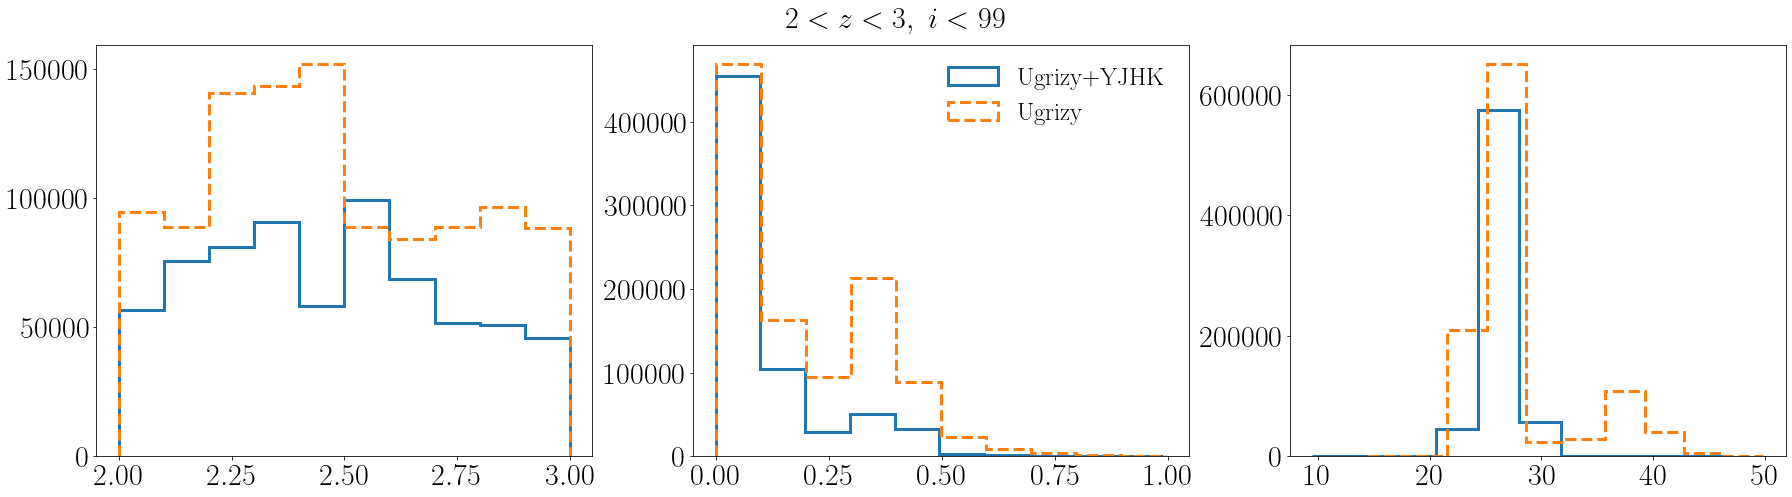

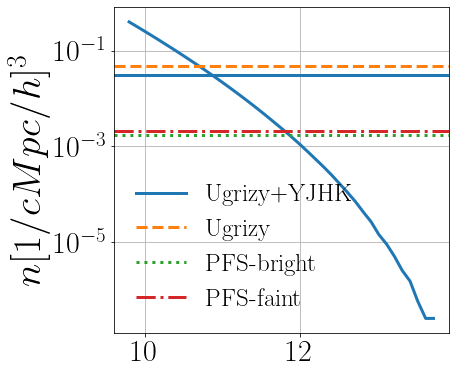

In [11]:
file_paths = [['/home/mahdi/HD2/LIM/Desprez2023/COSMOS_11bands-SExtractor-Lephare.fits',
            '/home/mahdi/HD2/LIM/Desprez2023/XMMLSS_11bands-SExtractor-Lephare.fits'],
            ['/home/mahdi/HD2/LIM/Desprez2023/COSMOS_6bands-SExtractor-Lephare.fits',
            '/home/mahdi/HD2/LIM/Desprez2023/XMMLSS_6bands-SExtractor-Lephare.fits']]
labels = ['Ugrizy+YJHK', 'Ugrizy']
area = np.array([1.4+4.1, 1.4+4.1]) # From section 2.1 (Table 2) of Desprez+23, in deg^2
counts = get_photz_dist_sextractor(file_paths=file_paths, labels=labels, area=area)
# The PFS specteroscopy, from Table3 of Greene+22
area = np.append(area, [1.3,1.3])
counts = np.append(counts, [8300+770, 8300+770+1800])
labels.append('PFS-bright')
labels.append('PFS-faint')
ndens = [get_num_density(counts=counts[i], area=area[i]) for i in range(4)]
get_mass_complteness(ndens=ndens, labels=labels)

| i <= 24 |
counts:
..........................
Ugrizy+YJHK, 26.893 k
Ugrizy, 46.354 k

Counts per 1.3 deg^2 :
..........................
Ugrizy+YJHK : 6.356 k
Ugrizy : 10.956 k

sigma_z: 
..........................
Ugrizy+YJHK : 0.009601547219482308
Ugrizy : 0.023824229836463928

Mass completeness :
..........................
Ugrizy+YJHK  12.01426276182517
Ugrizy  11.812966077755659

+++++++++++++++++++++++++++++++++++++++++++++++

| i <= 24.5 |
counts:
..........................
Ugrizy+YJHK, 61.506 k
Ugrizy, 101.081 k

Counts per 1.3 deg^2 :
..........................
Ugrizy+YJHK : 14.537 k
Ugrizy : 23.891 k

sigma_z: 
..........................
Ugrizy+YJHK : 0.012190903845198876
Ugrizy : 0.029422465711832047

Mass completeness :
..........................
Ugrizy+YJHK  11.712317735720903
Ugrizy  11.511021051651392

+++++++++++++++++++++++++++++++++++++++++++++++

| i <= 25 |
counts:
..........................
Ugrizy+YJHK, 116.716 k
Ugrizy, 189.951 k

Counts per 1.3 deg^2 :
...........

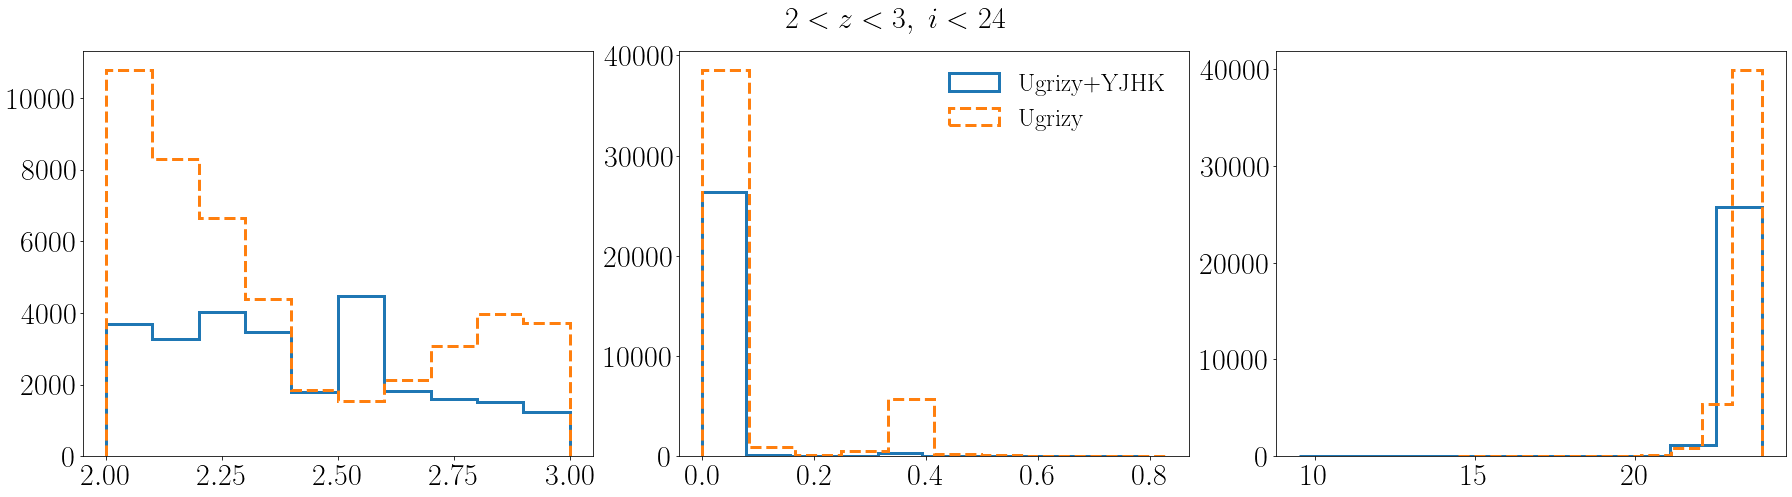

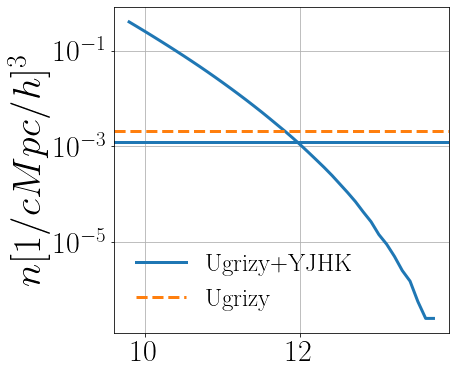

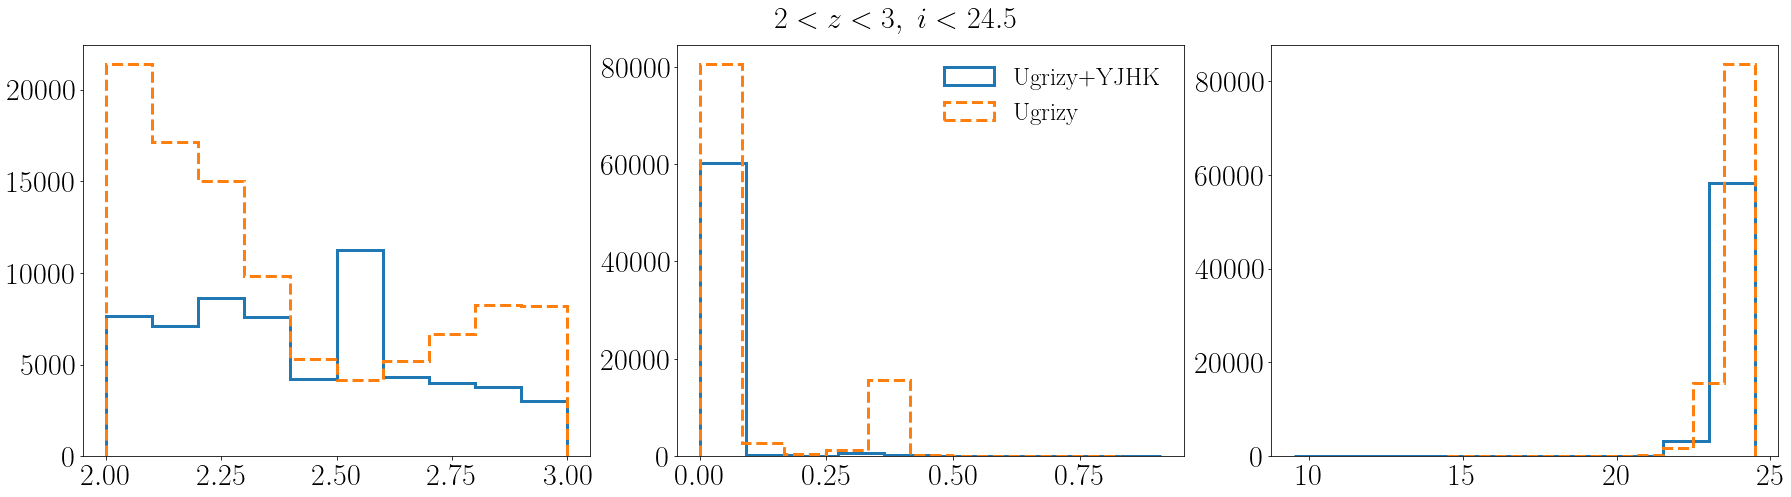

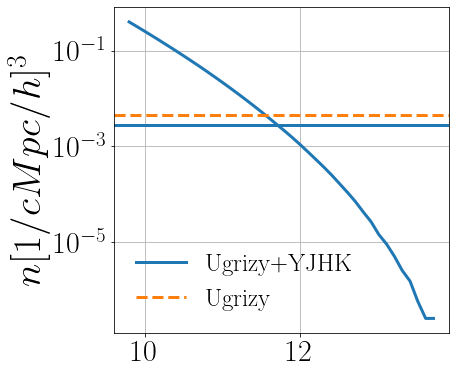

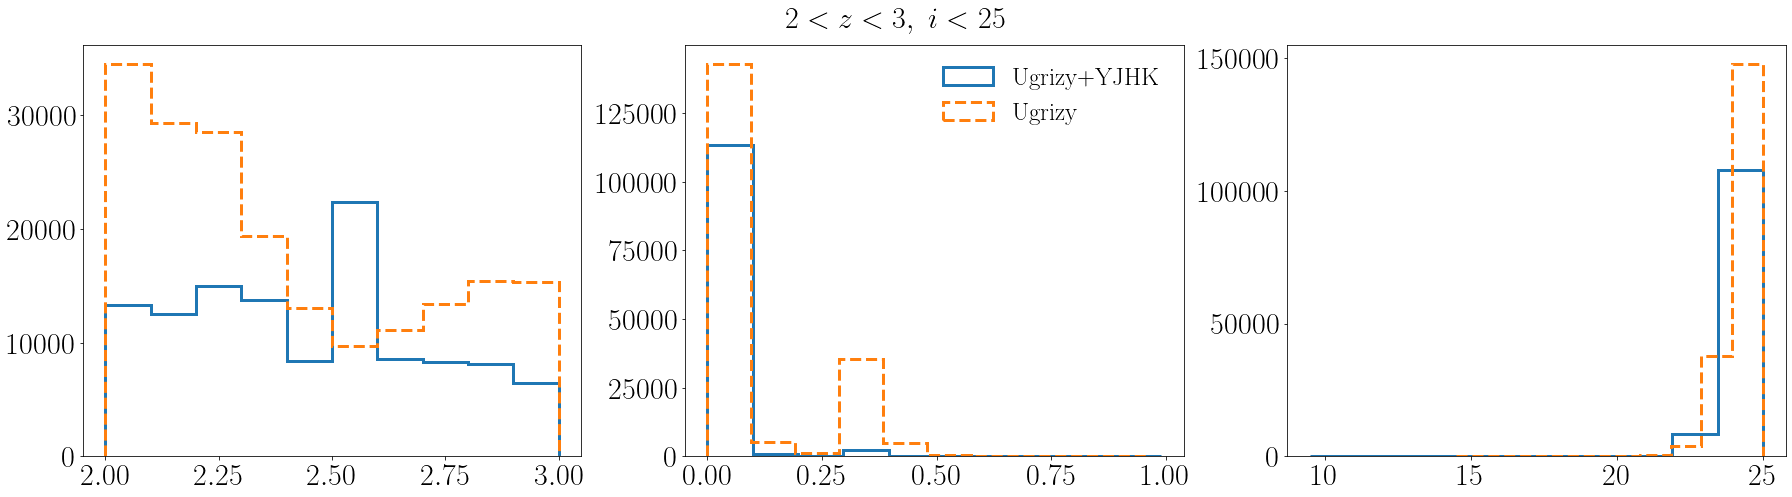

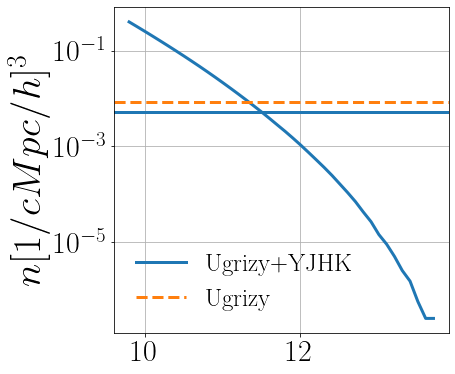

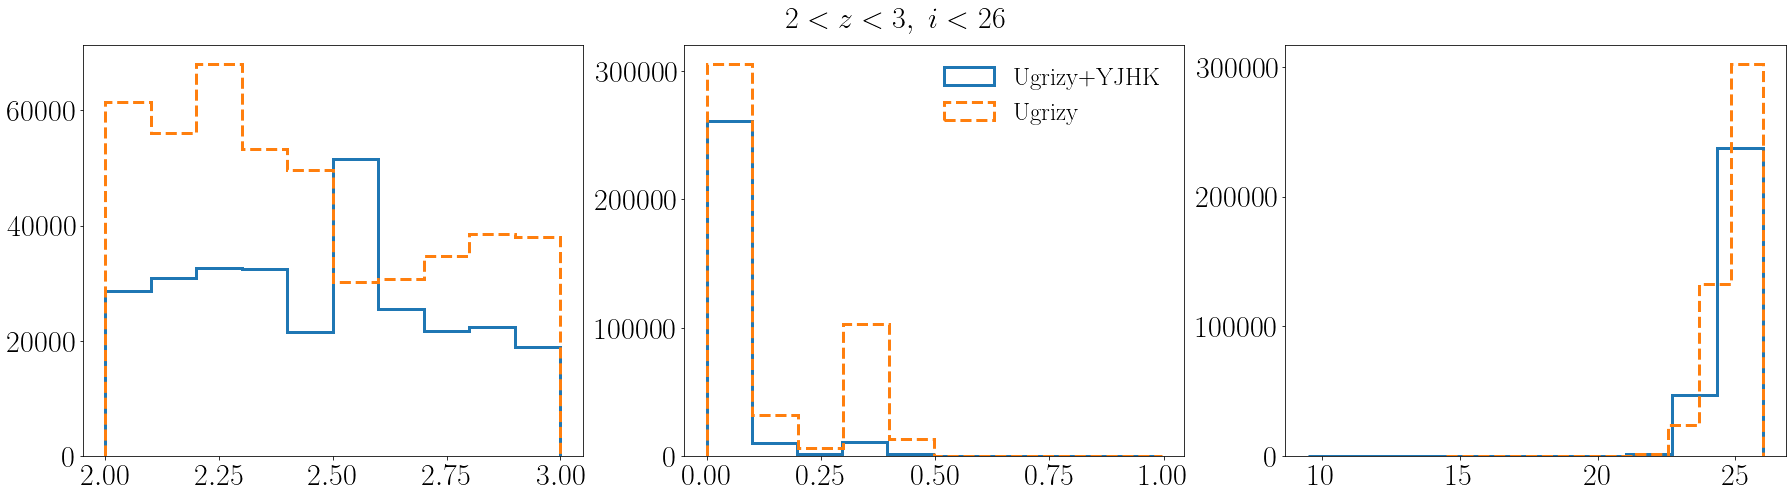

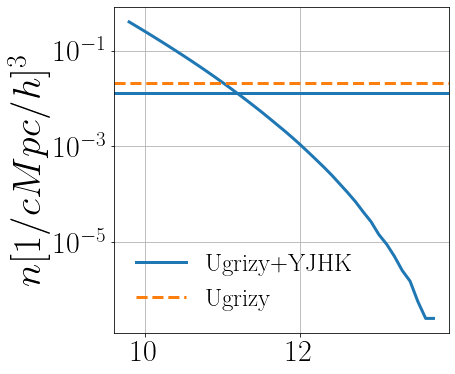

In [12]:
file_paths = [['/home/mahdi/HD2/LIM/Desprez2023/COSMOS_11bands-SExtractor-Lephare.fits',
            '/home/mahdi/HD2/LIM/Desprez2023/XMMLSS_11bands-SExtractor-Lephare.fits'],
            ['/home/mahdi/HD2/LIM/Desprez2023/COSMOS_6bands-SExtractor-Lephare.fits',
            '/home/mahdi/HD2/LIM/Desprez2023/XMMLSS_6bands-SExtractor-Lephare.fits']]
labels = ['Ugrizy+YJHK', 'Ugrizy']
area = np.array([1.4+4.1, 1.4+4.1]) # From section 2.1 (Table 2) of Desprez+23, in deg^2
for i in [24,24.5, 25,26]:
    print(f'| i <= {i} |')
    counts = get_photz_dist_sextractor(file_paths=file_paths, labels=labels, area=area, mag_cut=i)
    ndens = [get_num_density(counts=counts[i], area=area[i]) for i in range(len(file_paths))]
    get_mass_complteness(ndens=ndens, labels=labels)
    print('')
    print('+++++++++++++++++++++++++++++++++++++++++++++++')
    print('')


## For Exclaim:


Mass completeness :
..........................
HSC-N  11.611669393686148


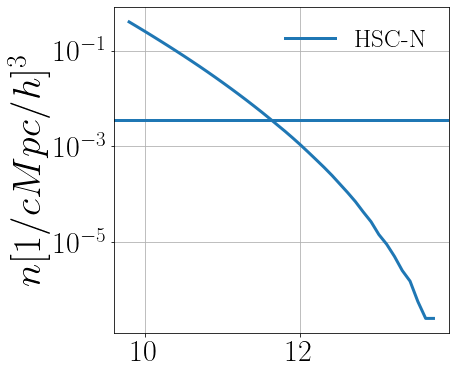

In [13]:
ndens = [3.6e-3]
labels=['HSC-N']
get_mass_complteness(ndens=ndens, labels=labels)